In [1]:
from __future__ import division

import argparse, time, logging, random, math, os, sys

import numpy as np
import mxnet as mx
import gluoncv as gcv
from skimage import util as sk_util
import cv2

from datetime import datetime
from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory, LRSequential, LRScheduler
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [2]:
per_device_batch_size = 128 # Batch Size for Each GPU
num_workers = 2             # Number of data loader workers
dtype = 'float32'           # Default training data type if float32
num_gpus = 1                # number of GPUs to use
batch_size = per_device_batch_size * num_gpus # Calculate effective total batch size

# For CIFAR100 Dataset:
num_classes = 100
num_images_per_class = 500
num_training_samples = num_classes * num_images_per_class
num_batches = num_training_samples // batch_size

## Smoothing

In [3]:
label_smoothing = True
def smooth(label, num_classes, eta=0.1):
    if isinstance(label, nd.NDArray):
        label = [label]
    smoothed = []
    for l in label:
        res = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                     off_value = eta/num_classes)
        smoothed.append(res)
    return smoothed
print("\nUsing label smoothing: {}".format(label_smoothing))


Using label smoothing: True


## Mixup

In [4]:
mixup = False
def mixup_transform(label, num_classes, lam=1, eta=0.0):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    res = []
    for l in label:
        y1 = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                    off_value = eta/num_classes)
        y2 = l[::-1].one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                          off_value = eta/num_classes)
        res.append(lam*y1 + (1-lam)*y2)
    return res
print("Using mixup: {}".format(mixup))

Using mixup: False


In [5]:
stitch_mixup = True
stitch_type = 'vertical'
def stitch_mixup_transform(X, lam, stitch_type='horizontal'):
    h1 = 32
    w1 = 32
    if lam < 1:
        Y = nd.zeros_like(X)
        if stitch_type == 'horizontal':
            Y[:,:,0:int(h1*lam),:] = X[:,:,0:int(h1*lam),:]
            Y[:,:,int(h1*lam):h1,:] = X[::-1,:,int(h1*lam):h1,:]
        elif stitch_type == 'vertical':
            Y[:,:,:,0:int(h1*lam)] = X[:,:,:,0:int(h1*lam)]
            Y[:,:,:,int(h1*lam):h1] = X[::-1,:,:,int(h1*lam):h1]
        else:
            raise("Invalid stitch type passed in!")
            return
        return Y
    else:
        return X
    
def stitch_mixup_label_transform(label, num_classes, lam=1, eta=0.0, stitch_type='horizontal'):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    res = []
    for l in label:
        y1 = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                    off_value = eta/num_classes)
        y2 = l[::-1].one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                          off_value = eta/num_classes)
        res.append(lam*y1 + (1-lam)*y2)
    return res
print("Using spatial mixup: {}".format(stitch_mixup))
if stitch_mixup:
    print("Using {} spatial mixup.".format(stitch_type))

Using spatial mixup: True
Using vertical spatial mixup.


In [6]:
def add_img_noise(img_tensor, noise_type='gaussian'):
    """
    """
    reshaped_img = nd.reshape(img_tensor, (32, 32, 3))
    noise_img_numpy = sk_util.random_noise(reshaped_img.asnumpy(), 
                                           mode=noise_type, 
                                           seed=None, 
                                           clip=True)
    noise_img = nd.reshape(nd.array(noise_img_numpy), (3, 32, 32))
    return noise_img

# Model Init

In [7]:
ctx = [mx.gpu(i) for i in range(num_gpus)]

# last_gamma = False
# print("Using last gamma: {}".format(last_gamma))
# kwargs = {'ctx':ctx, 'classes':num_classes, 'last_gamma':last_gamma}

kwargs = {'ctx':ctx, 'classes':num_classes}

use_group_norm = False
if use_group_norm:
    kwargs['norm_layer'] = gcv.nn.GroupNorm
    print("Using Group Normalization: {}".format(use_group_norm))

default_init = True
net = get_model('cifar_resnet56_v1', **kwargs)

if default_init:
    net.initialize(mx.init.Xavier(), ctx = ctx)
else:
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    print("Using MSRA Prelu Init.")

net.cast(dtype)
print("\nModel Init Done.")


Model Init Done.


# Distillation
Note that the reference paper uses a teacher model that was trained using cosine learning rate decay and label smoothing. 

Therefore I have created a separate notebook that trains the ResNext29_16x64d model using cosine learning rate decay and label smoothing on the CIFAR100 dataset. Training this ResNext29 architecture took nearly 10 hours...

What is left to do is now just to load the model architecture again, and load the parameters from the saved file.

### The old approach, when not using my own trained model is:
Load the pre-trained CIFAR10 models and replace the final output layer with 100 classes instead of 10. This is demonstrated at this website: https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/image/pretrained_models.html

Need to investigate WideResNet issue of having Top1-Val Accuracies becoming 0.00000 at the very beginning of training. 

Additionally, need to understand the two ResNeXt architectures to understand why training time is much longer...:/

In [8]:
distillation = True

if distillation:
    curr_dir = os.getcwd()
    param_file = os.path.join(curr_dir, "resnext29_teacher_mixupFalse.params") 
    T = 20
    hard_weight = 0.5
    # Teacher model for distillation training
    # teacher_name = 'cifar_resnet110_v2'
    # teacher_name = 'cifar_resnet56_v2'
    # teacher_name = 'cifar_wideresnet28_10' # Top1-Val is 0...
    # teacher_name = 'cifar_wideresnet40_8'  # Might cause the same problem
    # teacher_name = 'cifar_resnext29_32x4d' # This is apparently not available...?
    
#     teacher = get_model(teacher_name, pretrained=True, ctx=ctx)
#     teacher.collect_params().initialize(ctx=ctx, force_reinit=True) # Don't do this.
#     teacher.cast(dtype)
#     with teacher.name_scope():
#         teacher.output = gluon.nn.Dense(num_classes)
#         teacher.output.initialize(mx.init.Xavier(), ctx=ctx)
    teacher_name = 'cifar_resnext29_16x64d'
    teacher = get_model(teacher_name, classes=num_classes, ctx=ctx)
    teacher.initialize(mx.init.Xavier(), ctx=ctx)
    teacher.load_parameters(param_file)
    teacher.cast(dtype)
    print("\nTeacher Model Init Done!")
else:
    print("\nNot using distillation")


Teacher Model Init Done!


In [9]:
resize = 32
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
max_aspect_ratio = 4.0 / 3.0
min_aspect_ratio = 3.0 / 4.0
max_random_area = 1
min_random_area = 0.08
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([    
#     transforms.RandomResizedCrop(resize,
#                                  scale=(min_random_area, max_random_area), 
#                                  ratio=(min_aspect_ratio, max_aspect_ratio)),
    
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    
    transforms.RandomBrightness(brightness=jitter_param),
    transforms.RandomSaturation(saturation=jitter_param),
    transforms.RandomHue(hue=jitter_param),
    
    transforms.RandomLighting(lighting_param),
    
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
        
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize(mean_rgb, std_rgb),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb),
])
print("Preprocessing Step Successful.")

Preprocessing Step Successful.


# Compose Image Transforms

In [10]:
# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=True).transform_first(transform_train),
    batch_size=batch_size, 
    shuffle=True, 
    last_batch='discard', 
    num_workers=num_workers)

# Set train=False for validation data
# Set shuffle=False to shuffle the testing data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=False).transform_first(transform_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)
print("Initialization of train_data and val_data successful.")
print("Per Device Batch Size: {}".format(per_device_batch_size))

Initialization of train_data and val_data successful.
Per Device Batch Size: 128


# Training Settings

In [11]:
if mixup or stitch_mixup:
    epochs = 200 # Mixup asks for longer training to converge better
else:
    epochs = 120
    
warmup_epochs = 5
mixup_off_epochs = 0

alpha = 0.2 # For Beta distribution sampling

lr_decay_epochs = [30, 60, 90, np.inf] # Epochs where learning rate decays
# lr_decay_epochs = [40, 80]

warmup_lr_mode = 'linear'
lr_mode = 'cosine'
lr_decay = 0.1 # Learning rate decay factor
target_lr = 0

# Sets up a linear warmup scheduler, followed by a cosine rate decay.
# Consult the paper for the proper parameters (base_lr, target_lr, warmup_epochs, etc.)
lr_scheduler = LRSequential([
    LRScheduler(warmup_lr_mode,
                base_lr = 0,
                target_lr = 0.1,
                nepochs = warmup_epochs,
                iters_per_epoch = num_batches),
    
    LRScheduler(lr_mode,
                base_lr = 0.1,
                target_lr = target_lr,
                nepochs = epochs - warmup_epochs,
                iters_per_epoch = num_batches,
                step_epoch = lr_decay_epochs,
                step_factor = lr_decay,
                power = 2)
])

# Nesterov accelerated gradient descent and set parameters (based of off 
# reference papers and default values):
optimizer = 'nag'
optimizer_params = {'lr_scheduler': lr_scheduler, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

if label_smoothing or mixup:
    sparse_label_loss = False
else:
    sparse_label_loss = True

print("sparse label loss: {}".format(sparse_label_loss))

if distillation:
    loss_fn = gcv.loss.DistillationSoftmaxCrossEntropyLoss(temperature=T,
                                                           hard_weight=hard_weight,
                                                           sparse_label=sparse_label_loss)
else:
    loss_fn = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=sparse_label_loss)

train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("\nUsing label smoothing: {}".format(label_smoothing))
print("\nUsing mixup: {}".format(mixup))
print("Number of no-mixup epochs:{}".format(mixup_off_epochs))

print("\nUsing {} Optimizer".format(optimizer))
print(optimizer_params)
print("\nNumber of warmup epochs: {}".format(warmup_epochs))
print("Warmup Learning Rate Mode: {}".format(warmup_lr_mode))
print("Learing Rate Mode: {}".format(lr_mode))
print("Learing Rate Decay: {}".format(lr_decay))
print("Learning Rate Decay Epochs: {}".format(lr_decay_epochs))
print("\nTraining Settings Set Successfully.")

sparse label loss: False

Using label smoothing: True

Using mixup: False
Number of no-mixup epochs:0

Using nag Optimizer
{'lr_scheduler': <gluoncv.utils.lr_scheduler.LRSequential object at 0x7ff098113c90>, 'wd': 0.0001, 'momentum': 0.9}

Number of warmup epochs: 5
Warmup Learning Rate Mode: linear
Learing Rate Mode: cosine
Learing Rate Decay: 0.1
Learning Rate Decay Epochs: [30, 60, 90, inf]

Training Settings Set Successfully.


# Test Function

In [12]:
acc_top1 = mx.metric.Accuracy()
acc_top5 = mx.metric.TopKAccuracy(5)

def test(ctx, val_data):
    acc_top1.reset()
    acc_top5.reset()
    
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X.astype(dtype, copy=False)) for X in data]
        acc_top1.update(label, outputs)
        acc_top5.update(label, outputs)
    
    _, top1 = acc_top1.get()
    _, top5 = acc_top5.get()
    
    return (top1, top5)

# Training Loop

Training loop started for 200 epochs:
[Epoch 0] train=1.000000 val_top1=0.142900 val_top5=0.465600 loss=46076205.757812 time: 178.070246
[Epoch 1] train=1.000000 val_top1=0.241200 val_top5=0.620900 loss=46064843.179688 time: 173.180571
[Epoch 2] train=1.000000 val_top1=0.301800 val_top5=0.713000 loss=46059284.109375 time: 173.127849
[Epoch 3] train=1.000000 val_top1=0.349900 val_top5=0.759100 loss=46053881.570312 time: 174.720312
[Epoch 4] train=1.000000 val_top1=0.427500 val_top5=0.810800 loss=46048947.671875 time: 179.203099
[Epoch 5] train=1.000000 val_top1=0.439900 val_top5=0.815300 loss=46045148.851562 time: 180.324555
[Epoch 6] train=1.000000 val_top1=0.498100 val_top5=0.848100 loss=46042072.000000 time: 174.626389
[Epoch 7] train=1.000000 val_top1=0.488200 val_top5=0.830600 loss=46039083.421875 time: 177.415295
[Epoch 8] train=1.000000 val_top1=0.540500 val_top5=0.874300 loss=46037346.687500 time: 174.893756
[Epoch 9] train=1.000000 val_top1=0.552200 val_top5=0.887200 loss=46035

[Epoch 82] train=1.000000 val_top1=0.727100 val_top5=0.943800 loss=46016652.132812 time: 176.959264
[Epoch 83] train=1.000000 val_top1=0.690200 val_top5=0.936100 loss=46015158.367188 time: 174.433114
[Epoch 84] train=1.000000 val_top1=0.727000 val_top5=0.943300 loss=46015598.781250 time: 175.664763
[Epoch 85] train=1.000000 val_top1=0.741500 val_top5=0.948200 loss=46016141.781250 time: 175.300522
[Epoch 86] train=1.000000 val_top1=0.747100 val_top5=0.949900 loss=46016532.687500 time: 174.436261
[Epoch 87] train=1.000000 val_top1=0.737000 val_top5=0.947400 loss=46015226.351562 time: 173.667072
[Epoch 88] train=1.000000 val_top1=0.745700 val_top5=0.949600 loss=46015554.898438 time: 177.662644
[Epoch 89] train=1.000000 val_top1=0.752300 val_top5=0.951000 loss=46015470.523438 time: 173.291411
[Epoch 90] train=1.000000 val_top1=0.737600 val_top5=0.947200 loss=46014647.859375 time: 173.118110
[Epoch 91] train=1.000000 val_top1=0.750000 val_top5=0.949900 loss=46015420.882812 time: 173.742399


[Epoch 164] train=1.000000 val_top1=0.797900 val_top5=0.958100 loss=46006127.773438 time: 175.639162
[Epoch 165] train=1.000000 val_top1=0.803500 val_top5=0.956300 loss=46005196.984375 time: 182.219224
[Epoch 166] train=1.000000 val_top1=0.801900 val_top5=0.959600 loss=46005412.875000 time: 179.044964
[Epoch 167] train=1.000000 val_top1=0.806300 val_top5=0.960400 loss=46004522.382812 time: 179.142330
[Epoch 168] train=1.000000 val_top1=0.803000 val_top5=0.959500 loss=46005407.250000 time: 179.816833
[Epoch 169] train=1.000000 val_top1=0.806300 val_top5=0.958100 loss=46004027.617188 time: 176.574837
[Epoch 170] train=1.000000 val_top1=0.806200 val_top5=0.960600 loss=46005374.328125 time: 177.386111
[Epoch 171] train=1.000000 val_top1=0.807200 val_top5=0.959600 loss=46004748.781250 time: 177.619010
[Epoch 172] train=1.000000 val_top1=0.806700 val_top5=0.961900 loss=46004890.414062 time: 180.511774
[Epoch 173] train=1.000000 val_top1=0.806500 val_top5=0.959300 loss=46003951.492188 time: 1

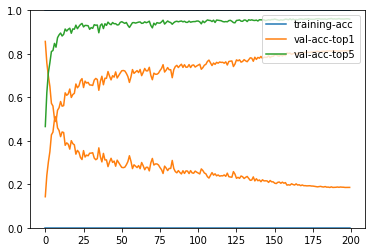

In [13]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("Training loop started for {} epochs:".format(epochs))
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data  = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        if mixup or stitch_mixup:
            if mixup and not(stitch_mixup):
                lam = np.random.beta(alpha, alpha)
                if epoch >= epochs - mixup_off_epochs:
                    lam = 1
                data = [lam*X + (1-lam)*X[::-1] for X in data]
            
                if label_smoothing:
                    eta = 0.1
                else:
                    eta = 0.0
                label = mixup_transform(label, num_classes, lam, eta)
            
            elif stitch_mixup and not(mixup):
                lam = np.random.beta(alpha, alpha)
                if lam < 0.1:
                    lam = 1
                if epoch >= epochs - mixup_off_epochs:
                    lam = 1
                data = [stitch_mixup_transform(X, lam) for X in data]
                
                if label_smoothing:
                    eta = 0.1
                else:
                    eta = 0.0
                label = stitch_mixup_label_transform(label, num_classes, lam, eta)
            
            else:
                print("No Mixup.")
        
        elif label_smoothing:
            hard_label = label
            label = smooth(label, num_classes)
        
        if distillation:
            teacher_prob = [nd.softmax(teacher(X.astype(dtype, copy=False)) / T) for X in data]

        # AutoGrad
        with ag.record():
            outputs = [net(X.astype(dtype, copy=False)) for X in data]
            if distillation:
                loss = [loss_fn(yhat.astype(dtype, copy=False),
                                y.astype(dtype, copy=False),
                                p.astype(dtype, copy=False)) for yhat, y, p in zip(outputs, 
                                                                                   label, 
                                                                                   teacher_prob)]
            else:
                loss = [loss_fn(yhat, y) for yhat, y in zip(outputs, label)]
            
        # Backpropagation
        for l in loss:
            l.backward()
        
        train_loss += sum([l.sum().asscalar() for l in loss])
            
        # Optimize
        trainer.step(batch_size)
        
        # Update metrics
        if mixup or stitch_mixup:
            output_softmax = [nd.SoftmaxActivation(out.astype(dtype, copy=False)) \
                              for out in outputs]
            train_metric.update(label, output_softmax)
        else:
            if label_smoothing:
                train_metric.update(hard_label, outputs)
            else:
                train_metric.update(label, outputs)

    name, acc = train_metric.get()
    
    # Evaluate on Validation data
    #name, val_acc = test(ctx, val_data)
    val_acc_top1, val_acc_top5 = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc_top1])
    train_history2.update([acc, val_acc_top1, val_acc_top5])
    
    print('[Epoch %d] train=%f val_top1=%f val_top5=%f loss=%f time: %f' %
        (epoch, acc, val_acc_top1, val_acc_top5, train_loss, time.time()-tic))

# We can plot the metric scores with:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_history.plot(['training-error', 'validation-error'], 
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_errors_{t}.png".format(o=optimizer,
                                                                                           ep=epochs,
                                                                                           t=timestamp))
train_history2.plot(['training-acc', 'val-acc-top1', 'val-acc-top5'],
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_accuracies_{t}.png".format(o=optimizer,
                                                                                               ep=epochs,
                                                                                               t=timestamp))
print("Done.")